# The column space of NLP embedding vectors in regression models

Exploration of the embedding vectors for ~3000 text sentiment cases. Are they unitary? Independent? How well do they work in a linear regression? We find that some of the dimensions in the vectors are duplicated by the NN that generated them.  We see what the effect is of removing them, or alternately of applying principal components analysis to reduce the design matrix column space. 

JMA March 2024

In [106]:
import pandas as pd
import numpy as np
import os
# For vector norms, and determinants. 
import numpy.linalg as la
# Plotting
import seaborn as sns
# use statsmodels to compute regression standard errors
# since scikit learn doesn't compute them.
import statsmodels.api as sm
# use to create the embeddings
# See  https://www.sbert.net/
from sentence_transformers import SentenceTransformer, util # use sbert's cosine similarity measure
EMBEDDING_DIMENSIONS = 384     # This model creates vectors of this length. 
# Principal component analysis
from sklearn.decomposition import PCA, TruncatedSVD
# The random number generator can be used to select a random set of columns for visualization
from numpy.random import Generator, PCG64
rng = Generator(PCG64())

In [76]:
# Load the embedding vectors dataset 
if os.environ['HOME'] == '/Users/jma':
    featurized_parquet_file = '/Users/jma/Library/CloudStorage/OneDrive-Personal/' +\
    'teaching/sjsu/ISE201/ISE 201 - Math Foundations for Decision and Data Science/embeddings/' +\
    'sentence_embeddings.parquet'
else:
    featurized_parquet_file = 'data/sentence_embeddings.parquet'

text_df = pd.read_parquet(featurized_parquet_file)

# Load the embedding vectors and create the design matrix

In [77]:
# The review column contains varying-length text that was converted into the vector embeddings
# Sentiment is a 0, 1 label that classifies the text as either positive or negative
# The embedding vectors are stuffed into a the last column
text_df

,review,sentiment,vector
0,So there is no way for me to plug it in here i...,0,"[0.08027008920907974, -0.04396028444170952, -0..."
1,"Good case, Excellent value.",1,"[-0.009648566134274006, 0.10622689127922058, 0..."
2,Great for the jawbone.,1,"[-0.07081733644008636, 0.07361650466918945, 0...."
3,Tied to charger for conversations lasting more...,0,"[-0.0739610344171524, 0.06734045594930649, 0.0..."
4,The mic is great.,1,"[-0.09819574654102325, 0.010798277333378792, 0..."
...,...,...,...
743,I just got bored watching Jessice Lange take h...,0,"[-0.02032049186527729, -0.07333985716104507, 0..."
744,"Unfortunately, any virtue in this film's produ...",0,"[-0.025788182392716408, 0.007497682701796293, ..."
745,"In a word, it is embarrassing.",0,"[0.026193976402282715, 0.022175997495651245, 0..."
746,Exceptionally bad!,0,"[-0.027648691087961197, -0.004298456944525242,..."


In [103]:
# Build the design matrix
Xmatrix = np.array([v for v in text_df['vector']])
print('Design matrix shape ', Xmatrix.shape)
# Center the feature vectors 
Xcentered = Xmatrix - Xmatrix.mean(axis=1)[:,np.newaxis]
y = text_df['sentiment']

# Check if the embedding vectors (rows) are normalized
embedding_norms = np.apply_along_axis(la.norm, 1, Xcentered)
# Count the rows, and show which are the shortest and longest 
embedding_norms.shape, min(embedding_norms), max(embedding_norms)

Design matrix shape  (2748, 384)


((2748,), 0.9976173123218056, 1.000000054979317)

In [79]:
# What do the embedding means look like before we zeroed them?
pd.DataFrame(Xmatrix.mean(axis=1)[:,np.newaxis]).describe()

,0
count,2.748000e+03
mean,5.956439e-04
std,8.588821e-04
min,-1.808999e-03
25%,8.564898e-07
50%,5.268461e-04
75%,1.167815e-03
max,3.520658e-03


In [80]:
# Lets look in the other dimension:
# what are the norms of the feature vectors? 
# Dont expect them to be  normalized.    
feature_norms = np.apply_along_axis(la.norm, 0, Xcentered)
feature_norms.shape, min(feature_norms), max(feature_norms)

((384,), 0.054784761147046245, 4.394484477913921)

# Check row and column properties 

Are the columns independent?

In [81]:
# The Gram matrix shows pairwise inner products 
# Some are entirely correlated (e.g. duplicated) !! 
# Look for duplicates in the samples 
symmetric_m = Xcentered.T @ Xcentered
# THe gram matrix is ill-conditioned
la.det(symmetric_m)

0.0

In [82]:
# check the self-inner products that are off diagonal
off_diagonals = symmetric_m.copy()
np.fill_diagonal(off_diagonals, 0)
print(np.min(off_diagonals), np.max(off_diagonals))
off_diagonals.shape

-9.017965357770224 8.401771053433926


(384, 384)

# Visualize the column dependencies

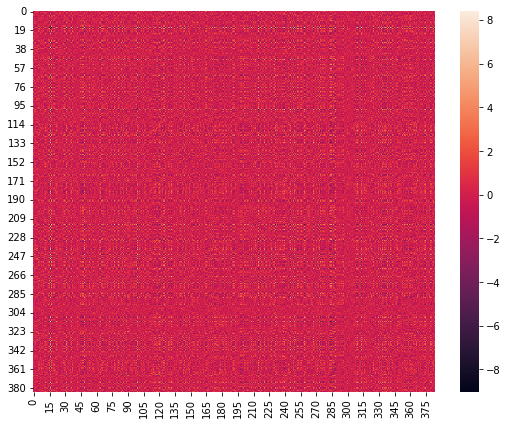

In [83]:
g = sns.heatmap(off_diagonals)
g.figure.set_size_inches(9, 7)

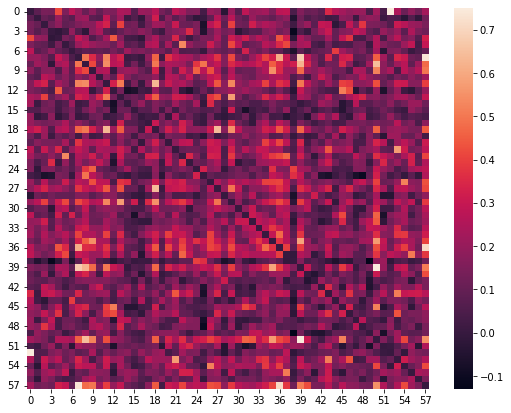

In [84]:
# Lets zoom into a few dimensions to get a better look.
# Look at some of the inner products -- are they orthogonal?
# Not at all - some of them are almost entirely correlated. 
how_many = 58
choices = np.random.choice(np.arange(EMBEDDING_DIMENSIONS), how_many, replace=False)
ev_samples = Xmatrix[choices, :].T
sampled_symmetric = ev_samples.T @ ev_samples
# Zero the diagonal, to see dependencies better
np.fill_diagonal(sampled_symmetric, 0)
g = sns.heatmap(sampled_symmetric)
g.figure.set_size_inches(9, 7)

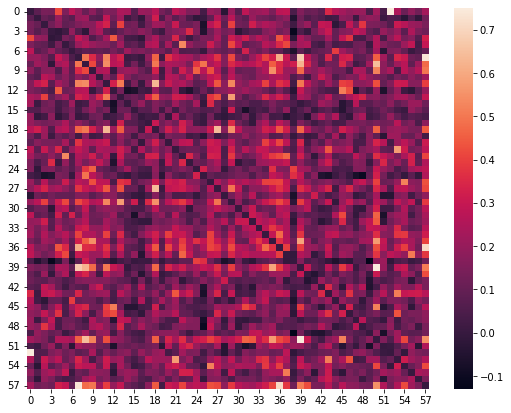

In [102]:
# Try the same measure using cosine similarity - looks about the same. 
# Sentence transformer libraries return pytorch tensors. 
cs = util.cos_sim(ev_samples.T, ev_samples.T).numpy()
np.fill_diagonal(cs, 0)
g = sns.heatmap(cs)
g.figure.set_size_inches(9, 7)

# Try running a regression with the embedding features

In [ ]:
# Run the OLS - The coefs are unstable because columns are dependent
# The column space is not full rank. 
# The result is an unstable set of coefs.
# Add the constant column to the design matrix
Xcentered = sm.add_constant(Xcentered) 
linear_model = sm.OLS(y, Xcentered).fit()
x = sorted(linear_model.params)
# Look at the first and last regression coefficients. Sigh. 
x[0:2], x[-3:-1]

([-1012553.8143639136, -1012553.8136360712],
 [1.0473869527253548, 1.1236575640612045])

In [ ]:
print(linear_model.summary())

                            OLS Regression Results                            
Dep. Variable:              sentiment   R-squared:                       0.709
Model:                            OLS   Adj. R-squared:                  0.662
Method:                 Least Squares   F-statistic:                     15.06
Date:                Fri, 15 Mar 2024   Prob (F-statistic):               0.00
Time:                        08:10:49   Log-Likelihood:                -299.62
No. Observations:                2748   AIC:                             1365.
Df Residuals:                    2365   BIC:                             3632.
Df Model:                         382                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5822      0.056     10.336      0.0

In [ ]:
# Check for duplicate columns among the 384 features. 
# By exhastively looking pairwise for those with the same length
# (A cosine-distance based test would be more precise. )
for i in range(384):
    for j in range(i):
        # print('.', end='')
        if abs(la.norm(Xcentered[:,i]) - la.norm(Xcentered[:,j])) < 1e-5:
            print(i,j)
    print(end = '-')

# Check the length of these with matching norms. 
lens =  [la.norm(Xcentered[:,i]) for i in range(384)]
[lens[i] for i in (84,103,128,224,320)]

-------------------------------------------------------------------------------------------------------103 84
-------------------------------------------------------------------------------------------------------------------------224 128
------------------------------------------------------------------------------------------------320 128
320 224
----------------------------------------------------------------

[2.3891741225514234,
 2.389172606665222,
 0.054784761147046245,
 0.054784761147046245,
 0.05478532317261061]

In [ ]:
# Remove the offending columns
Xselected = Xcentered.copy()
for i in (320, 224, 128, 103, 84):
    Xselected = np.delete(Xselected, i, axis = 1)

Xselected.shape


(2748, 380)

In [ ]:
# Check the Gram determinant to see if the columns are now linearly independent
la.det(Xselected.T @ Xselected)

2.0364764570955452e+169

In [ ]:
# These coefficients look better 
Xselected = sm.add_constant(Xselected) 
linear_model = sm.OLS(y, Xselected).fit()
x = sorted(linear_model.params)
x[0:2], x[-3:-1], max(x)

([-0.8830165845773759, -0.7109050945355888],
 [1.1493865718998408, 1.1562882409317297],
 1.1866604855387988)

In [ ]:
# And the linear model does not suffer from numerically unstable coefs. 
# with materially the same accuracy, but different coefficient values. 
# Note that even with centered outcome data there is a significant const (A bias?)
print(linear_model.summary())

                            OLS Regression Results                            
Dep. Variable:              sentiment   R-squared:                       0.708
Model:                            OLS   Adj. R-squared:                  0.661
Method:                 Least Squares   F-statistic:                     15.15
Date:                Fri, 15 Mar 2024   Prob (F-statistic):               0.00
Time:                        08:10:52   Log-Likelihood:                -303.04
No. Observations:                2748   AIC:                             1366.
Df Residuals:                    2368   BIC:                             3615.
Df Model:                         379                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5249      0.035     14.996      0.0

<AxesSubplot:>

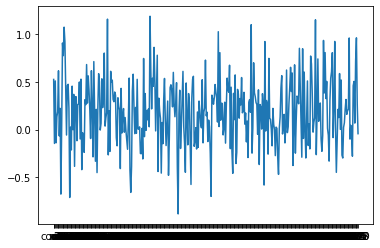

In [ ]:
# Visualize all the coefficients.  No extreme values. 
sns.lineplot(x=linear_model.params.index, y=linear_model.params.values)

# Another approach. Transform the feature space with PCA

In [ ]:
#  Run a PCA transformed linear regression on the same data.  
# THe accuracies should be the same
my_pca = PCA(n_components=384).fit(Xcentered)
X_pca = my_pca.transform(Xcentered)
X_pca = sm.add_constant(X_pca) 
pca_model = sm.OLS(y, X_pca).fit()
print(pca_model.summary())

                            OLS Regression Results                            
Dep. Variable:              sentiment   R-squared:                       0.709
Model:                            OLS   Adj. R-squared:                  0.662
Method:                 Least Squares   F-statistic:                     15.06
Date:                Fri, 15 Mar 2024   Prob (F-statistic):               0.00
Time:                        08:10:55   Log-Likelihood:                -299.62
No. Observations:                2748   AIC:                             1365.
Df Residuals:                    2365   BIC:                             3632.
Df Model:                         382                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5044      0.006     90.897      0.0

In [ ]:
# However the coefficients still suffer being unstable
min(pca_model.params.values), max(pca_model.params.values)

(-2480217.59449973, 1.416919467080097)

In [108]:
# Run the PCA on the data with dependent features removed.  Same result! 
# my_pca = PCA(n_components=379).fit(Xselected)

# Use just some of the first components
use_components = 40
my_pca = PCA(n_components=use_components).fit(Xselected)

X_pca = my_pca.transform(Xselected)
X_pca = sm.add_constant(X_pca) 
pca2_model = sm.OLS(y, X_pca).fit()
print(pca2_model.summary())

                            OLS Regression Results                            
Dep. Variable:              sentiment   R-squared:                       0.621
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     111.1
Date:                Fri, 15 Mar 2024   Prob (F-statistic):               0.00
Time:                        09:20:04   Log-Likelihood:                -660.01
No. Observations:                2748   AIC:                             1402.
Df Residuals:                    2707   BIC:                             1645.
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5044      0.006     85.294      0.0

In [109]:
# But the coefs are better behaved. 
min(pca2_model.params.values), max(pca2_model.params.values)

(-2.013443722497696, 0.5087133606836234)

# PCA component variances

<AxesSubplot:>

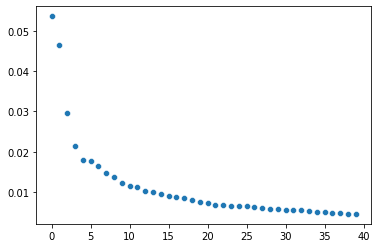

In [110]:
# View the analysis of variance over the pca components
sns.scatterplot(x=range(use_components), y=my_pca.explained_variance_[0:use_components])


<AxesSubplot:>

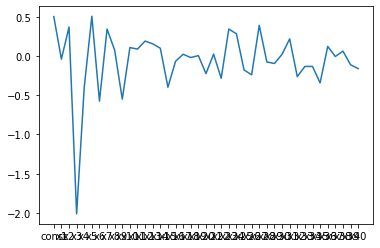

In [111]:
# Note how the coefficient magnitudes now vary with order. 
sns.lineplot(x=pca2_model.params.index, y=pca2_model.params.values)

# Recreate the same PCA transformation using SVD components

<AxesSubplot:>

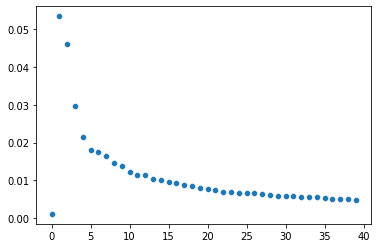

In [127]:
svd_model = TruncatedSVD(n_components=use_components)
svd_model.fit(Xselected)
sns.scatterplot(x=range(use_components), y=svd_model.explained_variance_)
# Why the spurious first point? 


In [128]:
# THe model fit is equivalent to the PCA version
# Apply the loadings to the X matrix, to create the subset of components. 
X_svd = (Xselected @ svd_model.components_.T)
X_svd = sm.add_constant(X_svd) 
svd_regression = sm.OLS(y, X_svd).fit()
print(svd_regression.summary())

                            OLS Regression Results                            
Dep. Variable:              sentiment   R-squared:                       0.621
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     110.9
Date:                Fri, 15 Mar 2024   Prob (F-statistic):               0.00
Time:                        09:35:22   Log-Likelihood:                -661.23
No. Observations:                2748   AIC:                             1404.
Df Residuals:                    2707   BIC:                             1647.
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3752      0.549      2.503      0.0

<AxesSubplot:>

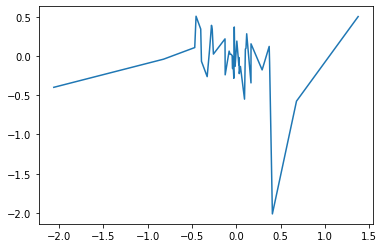

In [129]:
# Does the svd transform get the same coefficient values?
# Why not?? 
sns.lineplot(x=svd_regression.params.values, y=pca2_model.params.values)